In [3]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import ruptures as rpt
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, NoDataAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor, RobustThreshold)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster, KDEAnomalyScore1d,
                                 VIAnomalyScore, SpectralAnomalyScoreExt, MatrixProfileAnomalyScore,
                                 NoDataAnomalyScoreExt, ChangePointDetector, EnsembleAnomalyScore,
                                 GMMAnomalyScore)
import datetime as dt
#import pymc3 as pm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
import matplotlib
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [4]:
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2022-01-13T20:42:29.509 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


In [5]:
Temperature = 'FLOATVALUE'
spectral = Temperature + '_spectral'
spectralinv = Temperature + '_spectralinv'
signal = Temperature + '_energy'
rob = Temperature + '_rob'
nodata = Temperature + '_nodata'
cpd = Temperature + '_cpd'
cpd_sig = Temperature + '_cpd_sig'
cpd_inv = Temperature + '_cpd_inv_sig'

### Well known ph metrics example

I keep it here because it's illustrative.
Although the distribution isn't perfect the GMM approach turns out to be quite effective.

In [6]:
# deviceid ac2efe94-842d-3679-9f63-2d5365e01a11
# tag path ca3e/sws/ait2107/eu
df1_raw = pd.read_csv('./data/IOT_TAGDATA_TYPE_202106151143_ca3e_sws_ait2107_eu.csv',
                     parse_dates=['RCV_TIMESTAMP_UTC'], infer_datetime_format=True)
df1_raw['RCV_TIMESTAMP_UTC'] = pd.to_datetime(df1_raw['RCV_TIMESTAMP_UTC'], 
                                            format='%Y-%m-%d-%H.%M.%S.%f')
df1_raw = df1_raw.sort_values('RCV_TIMESTAMP_UTC').\
                  drop(columns=['TAGID','INTVALUE','STRINGVALUE', 'UPDATED_UTC', 'DATEVALUE',
                               'EVT_NAME', 'DEVICETYPE', 'LOGICALINTERFACE_ID', 'EVENTTYPE', 'FORMAT',])
df1_i = df1_raw.set_index(['DEVICEID','RCV_TIMESTAMP_UTC'])

In [7]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

gmmi = SpectralAnomalyScoreExt(Temperature, 12, spectral, spectralinv, signal)
et = gmmi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
gmmi._entity_type = et
df1_i = gmmi.execute(df=df1_i)

2022-01-13T20:42:30.986 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-01-13T20:42:31.003 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-01-13T20:42:31.003 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


<AxesSubplot:>

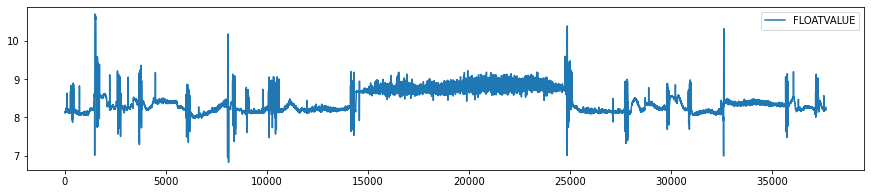

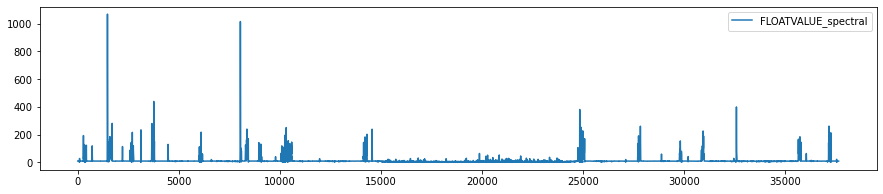

In [8]:
df1_i[['FLOATVALUE']].plot(use_index=False, figsize=(15,3))
df1_i[['FLOATVALUE_spectral']].plot(use_index=False, figsize=(15,3))

Text(0.5, 1.0, 'Almost bimodal distribution')

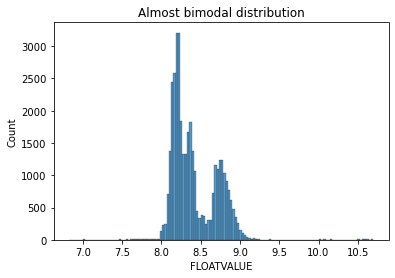

In [9]:
sns.histplot(data=df1_i[Temperature]).set_title('Almost bimodal distribution')

### Approximate bimodal distribution

by a sum of two Gaussians with a Gaussian Mixture Model

In [10]:
from mmfunctions.anomaly import GMMAnomalyScore
EngineLogging.configure_console_logging(logging.DEBUG)
gmm1 = GMMAnomalyScore(Temperature, 2, 3, 'gmm')
gmm1.delete_model = True
et = gmm1._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
gmm1._entity_type = et
df1_i = gmm1.execute(df=df1_i)

2022-01-13T20:42:31.748 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-01-13T20:42:31.749 DEBUG mmfunctions.anomaly.__init__ init GMM Estimator
2022-01-13T20:42:31.750 DEBUG root.__init__ __init__GMMAnomalyScore
2022-01-13T20:42:31.750 DEBUG root.__init__ __init__ done with parameters: FLOATVALUE.gmm
2022-01-13T20:42:31.751 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.7.0
2022-01-13T20:42:31.752 DEBUG iotfunctions.util.__init__ Starting trace
2022-01-13T20:42:31.752 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GMMAnomalyScore_20220113194231
2022-01-13T20:42:31.753 DEBUG iotfunctions.util.__init__ auto_save None
2022-01-13T20:42:31.753 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-01-13T20:42:31.754 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-01-13T20:42:31.754 DEBUG iotfunctions.met

In [11]:
# generated model after applying a MinMaxScaler
BGM1 = gmm1.active_models['ac2efe94-842d-3679-9f63-2d5365e01a11']['gmm']
"weights", BGM1.weights_, "means", BGM1.means_, "precision", BGM1.precisions_

('weights',
 array([0.48540313, 0.51459687]),
 'means',
 array([[0.46397103],
        [0.36072267]]),
 'precision',
 array([[[ 178.45025985]],
 
        [[1914.24178128]]]))

### Display the approximation with the additive model of two Gaussians

0 0 [[0.44715962]] [[0.48078243]]
1 1 [[0.35915547]] [[0.36228987]]


Text(0.5, 1.0, 'Gaussians after MinMax Scaling')

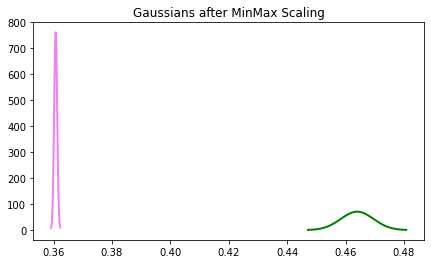

In [12]:
x = [None, None, None]
y = [None, None, None]
j = 0
for i in [0,1]:
    #mu = scaler.inverse_transform(BGM.means_[i])
    mu = BGM1.means_[i]
    sigma = 1/BGM1.precisions_[i]
    print (i, j, mu - 3*sigma, mu + 3*sigma)
    #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    x[j] = np.arange(mu - 3*sigma, mu + 3*sigma, 0.0001)

    #print (x)
    y[j] = sp.stats.norm.pdf(x[j], mu, sigma).reshape(-1,)
    j+=1
    #print (y)
    
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(x[0], y[0], color='green', lw=2)
ax.plot(x[1], y[1], color='violet', lw=2)
ax.set_title('Gaussians after MinMax Scaling')
#ax.plot(x[2], y[2], color='blue', lw=2)

In [13]:
# Show the anomaly score - everything above 6.6 is an outlier as e^(-6.6) is roughly 3 standard deviations away)
arr = df1_i['gmm'].copy()
arr[arr > 6.6] = 7
arr[arr <= 6.6] = np.nan

df1_i['anom'] = arr


In [14]:
#df1_i[['FLOATVALUE','gmm','anom']].plot(figsize=(15,7))
arr = np.arange(0,arr.size)

fig, ax = plt.subplots(1,1,figsize=(20,7))
fig.suptitle('Spectral and GMM anomaly score agree ..', fontsize=16, fontweight='bold')

ax.plot(arr, df1_i['FLOATVALUE'], color='green', lw=0.4)
#ax.plot(arr, df1_i['gmm'], color='violet', lw=0.4)
ax.scatter(arr, df1_i['anom'], color='red', lw=1)
ax.plot(arr, df1_i['FLOATVALUE_spectral']/100 + 4, color='orange', zorder=-1, lw=0.4)

2022-01-13T20:42:36.332 DEBUG matplotlib.font_manager._findfont_cached findfont: Matching sans\-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=16.0.
2022-01-13T20:42:36.333 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:36.334 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:36.335 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.335 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.336 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.05
2022-01-13T20:4

2022-01-13T20:42:36.364 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-SemiBold.ttf) normal normal 600 normal>) = 10.145
2022-01-13T20:42:36.364 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-MI.ttf) italic normal 500 normal>) = 11.24
2022-01-13T20:42:36.365 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dosis' (Dosis-SemiBold.otf) normal normal 600 normal>) = 10.145
2022-01-13T20:42:36.365 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-CondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T20:42:36.366 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Serif' (IBMPlexSerif-TextItalic.ttf) italic normal 450 normal>) = 11.2875
2022-01-13T20:42:36.366 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Knot BRK' (knot.ttf) normal normal 400 normal>) = 10

2022-01-13T20:42:36.393 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstFarsi' (KacstFarsi.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:36.394 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeMono' (FreeMono.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.394 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-ExtraCondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T20:42:36.395 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'OCRBE' (OCRBE.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.395 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-CondensedThinItalic.ttf) italic normal 100 condensed>) = 11.819999999999999
2022-01-13T20:42:36.395 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-ExtraCondensedMed

2022-01-13T20:42:36.422 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Looped Lao' (NotoLoopedLao-ExtraCondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:36.423 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.423 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rambling BRK' (rambling.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.423 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.25
2022-01-13T20:42:36.424 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Math' (MathJax_Math-BoldItalic.otf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:36.425 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Bright' (cmunbmo.ttf) obliqu

2022-01-13T20:42:36.445 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yrsa' (Yrsa-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.445 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Telugu' (NotoSerifTelugu-Light.ttf) normal normal 300 normal>) = 10.43
2022-01-13T20:42:36.445 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Telugu' (NotoSerifTelugu-SemiBold.ttf) normal normal 600 normal>) = 10.145
2022-01-13T20:42:36.446 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-ExtraBold.ttf) normal normal 800 normal>) = 10.145
2022-01-13T20:42:36.446 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Avestan' (NotoSansAvestan-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.447 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Upheaval TT BRK' (upheavtt.ttf) nor

2022-01-13T20:42:36.464 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fantasque Sans Mono' (FantasqueSansMono-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.465 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Sans' (lmsans8-oblique.otf) oblique normal 400 normal>) = 11.335
2022-01-13T20:42:36.465 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Aegean' (Aegean_hint.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.465 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Relapse BRK' (relapse.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.466 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-Black.ttf) normal normal 900 normal>) = 10.24
2022-01-13T20:42:36.466 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Mono Light' (lmmonolt10-bold.otf) normal normal

2022-01-13T20:42:36.484 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-Bold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.484 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'PT Sans Narrow' (PTN77F.ttf) normal normal 700 condensed>) = 10.25
2022-01-13T20:42:36.484 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GLYPHICONS Halflings' (glyphicons-halflings-regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.485 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-Condensed.ttf) normal normal 400 condensed>) = 10.535
2022-01-13T20:42:36.485 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Delphine' (Delphine.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.485 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-BoldCondItalic.o

2022-01-13T20:42:36.506 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quadratic Cal BRK' (quadrcal.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.506 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GFS Artemisia' (GFSArtemisiaBold.otf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.507 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-CondensedThinItalic.ttf) italic normal 100 condensed>) = 11.819999999999999
2022-01-13T20:42:36.507 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fidgety BRK' (fidgety.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.507 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dosis' (Dosis-ExtraBold.otf) normal normal 800 normal>) = 10.145
2022-01-13T20:42:36.508 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Verana Sans Demi' (VeranaSansDemi-Regular.otf) norm

2022-01-13T20:42:36.527 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-CondensedBold.ttf) normal normal 700 condensed>) = 10.25
2022-01-13T20:42:36.527 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Hmong Nyiakeng' (NotoSerifNyiakengPuachueHmong-Medium.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:36.528 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Museum' (MuseumFourteen.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.528 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-SemiCondensedExtraLight.ttf) normal normal 200 condensed>) = 10.725
2022-01-13T20:42:36.528 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gillius ADF' (GilliusADF-BoldCond.otf) normal normal 700 condensed>) = 10.25
2022-01-13T20:42:36.529 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IndUni-H' (

2022-01-13T20:42:36.549 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-SemiBold.ttf) normal normal 600 normal>) = 10.145
2022-01-13T20:42:36.549 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'API  PHON?TIQUE' (apibold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.550 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar-CondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T20:42:36.550 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-ExtraBold.ttf) normal normal 800 normal>) = 10.145
2022-01-13T20:42:36.551 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.551 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Outer Sider

2022-01-13T20:42:36.566 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Main' (MathJax_Main-Regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.566 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-ExtraCondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T20:42:36.567 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-ExtraLight.ttf) normal normal 200 normal>) = 10.525
2022-01-13T20:42:36.567 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-CondensedExtraBold.ttf) normal normal 800 condensed>) = 10.344999999999999
2022-01-13T20:42:36.567 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstPen' (KacstPen.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:36.568 DEBUG matplotlib.font_manager._findfont_cached findfont: s

2022-01-13T20:42:36.586 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Caliban' (Caliban.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.586 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-ExtraCondensedExtraBold.ttf) normal normal 800 condensed>) = 10.344999999999999
2022-01-13T20:42:36.587 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Open Sans' (OpenSans-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.587 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-ExtraBold.ttf) normal normal 800 normal>) = 10.145
2022-01-13T20:42:36.588 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hassle BRK' (hassle.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.588 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-CondensedBlack

2022-01-13T20:42:36.609 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Wyvern Wings Wyde BRK' (wyvernww.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.609 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Neural Outline BRK' (neuralol.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.610 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-CondensedThin.ttf) normal normal 100 condensed>) = 10.819999999999999
2022-01-13T20:42:36.610 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Averia Serif GWF' (AveriaSerifGWF-Regular.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:36.610 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Avdira' (Avdira_hint.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.611 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-ExtraCond

2022-01-13T20:42:36.631 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Courier Prime' (Courier Prime Italic.otf) normal normal 300 normal>) = 10.43
2022-01-13T20:42:36.631 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Abecedario_pautada' (AbecedarioPautada.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.632 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-SemiCondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:36.632 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari' (NotoSansDevanagari-Condensed.ttf) normal normal 400 condensed>) = 10.535
2022-01-13T20:42:36.633 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Soyombo' (NotoSansSoyombo-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.633 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 

2022-01-13T20:42:36.652 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Symbols' (NotoSansSymbols-ExtraLight.ttf) normal normal 200 normal>) = 10.525
2022-01-13T20:42:36.652 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'M+ 2p' (mplus-2p-thin.ttf) normal normal 100 normal>) = 10.62
2022-01-13T20:42:36.653 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Musica' (Musica_hint.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.653 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fascii Cross BRK' (fasciicr.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.654 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-SemiCondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:36.654 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal 700 normal>) =

2022-01-13T20:42:36.677 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ikarius ADF No2 Std' (IkariusADFNo2Std-Bold.otf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.677 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Oriya' (NotoSansOriya-Bold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.678 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Caladea' (Caladea-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.678 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Heros' (texgyreheros-regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.678 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Jupiter Crash BRK' (jupiterc.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.679 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-CondensedBlack.ttf) normal no

2022-01-13T20:42:36.700 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman' (lmroman8-regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.700 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'URW Gothic' (URWGothic-DemiOblique.otf) oblique normal 600 normal>) = 11.145
2022-01-13T20:42:36.700 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Meetei Mayek' (NotoSansMeeteiMayek-Thin.ttf) normal normal 100 normal>) = 10.62
2022-01-13T20:42:36.701 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-SemiCondensedExtraLight.ttf) normal normal 200 condensed>) = 10.725
2022-01-13T20:42:36.702 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Exaggerate BRK' (exagger8.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.702 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (No

2022-01-13T20:42:36.719 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstBook' (KacstBook.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:36.720 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DSEG7 Modern Mini' (DSEG7ModernMini-BoldItalic.ttf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:36.720 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Sans Thai Looped' (IBMPlexSansThaiLooped-Light.ttf) normal normal 300 normal>) = 10.43
2022-01-13T20:42:36.721 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Sans Thai' (IBMPlexSansThai-Thin.ttf) normal normal 100 normal>) = 10.62
2022-01-13T20:42:36.721 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Sans' (IBMPlexSans-Bold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.721 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Intersect O BRK' (interso.ttf) norma

2022-01-13T20:42:36.745 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-Regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.745 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Anonymous Pro Minus' (Anonymous Pro Minus BI.ttf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:36.745 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Verana Sans' (VeranaSans-Regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.746 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Gurmukhi' (NotoSansGurmukhi-SemiCondensedExtraBold.ttf) normal normal 800 condensed>) = 10.344999999999999
2022-01-13T20:42:36.746 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-ExtraLight.ttf) normal normal 200 normal>) = 10.525
2022-01-13T20:42:36.746 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<

2022-01-13T20:42:36.768 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tibetan' (NotoSerifTibetan-ExtraLight.ttf) normal normal 200 normal>) = 10.525
2022-01-13T20:42:36.769 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-Medium.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:36.769 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'M+ 2m' (mplus-2m-thin.ttf) normal normal 100 normal>) = 10.62
2022-01-13T20:42:36.769 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.535
2022-01-13T20:42:36.770 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-CondensedExtraLight.ttf) normal normal 200 condensed>) = 10.725
2022-01-13T20:42:36.770 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto S

2022-01-13T20:42:36.786 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Hebrew' (NotoSerifHebrew-SemiBold.ttf) normal normal 600 normal>) = 10.145
2022-01-13T20:42:36.787 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari' (NotoSansDevanagari-ExtraCondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T20:42:36.787 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-ExtraLight.ttf) normal normal 200 normal>) = 10.525
2022-01-13T20:42:36.787 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.788 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-SemiCondensedSemiBold.ttf) normal normal 600 condensed>) = 10.344999999999999
2022-01-13T20:42:36.788 DEBUG matplo

2022-01-13T20:42:36.815 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.535
2022-01-13T20:42:36.816 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cardo' (Cardob101.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.817 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-CondensedExtraBold.ttf) normal normal 800 condensed>) = 10.344999999999999
2022-01-13T20:42:36.818 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-CondensedExtraLight.ttf) normal normal 200 condensed>) = 10.725
2022-01-13T20:42:36.818 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Amalgamate O BRK' (amalgamo.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.819 DEBUG matplotlib.font_manager._findfont_cached findfont: score(

2022-01-13T20:42:36.846 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BABEL Unicode' (BABELita.ttf) italic normal 400 normal>) = 11.335
2022-01-13T20:42:36.846 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'eurofurence' (eurof55.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:36.847 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.847 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-CondensedSemiBold.ttf) normal normal 600 condensed>) = 10.344999999999999
2022-01-13T20:42:36.848 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Alegreya Sans SC' (AlegreyaSansSC-Regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.850 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Brigadoom BRK' (brigadom.ttf) normal normal 400 normal>) =

2022-01-13T20:42:36.874 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari' (NotoSansDevanagari-SemiCondensedExtraBold.ttf) normal normal 800 condensed>) = 10.344999999999999
2022-01-13T20:42:36.875 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Hebrew' (NotoSerifHebrew-CondensedExtraLight.ttf) normal normal 200 condensed>) = 10.725
2022-01-13T20:42:36.875 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.875 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-ExtraCondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:36.876 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Canadian Aboriginal' (NotoSansCanadianAboriginal-ExtraLight.ttf) normal normal 200 normal>) = 10.525
2022-01-13T20

2022-01-13T20:42:36.891 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Telugu' (NotoSansTelugu-CondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:36.891 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Kinnari' (Kinnari-Bold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.892 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tinos' (Tinos-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.892 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-SemiCondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T20:42:36.892 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.535
2022-01-13T20:42:36.893 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Sans Con

2022-01-13T20:42:36.914 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'RobotoBold' (Roboto-Bold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.915 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-SemiCondensedBold.ttf) normal normal 700 condensed>) = 10.25
2022-01-13T20:42:36.915 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rehearsal Offset BRK' (rehearso.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.915 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gillius ADF' (GilliusADF-BoldCondItalic.otf) italic normal 700 condensed>) = 11.25
2022-01-13T20:42:36.916 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Termes Math' (texgyretermes-math.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.916 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Math' (NotoSansMath-Regular

2022-01-13T20:42:36.935 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-ExtraCondensedBold.ttf) normal normal 700 condensed>) = 10.25
2022-01-13T20:42:36.935 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dustismo Roman' (Dustismo_Roman_Italic_Bold.ttf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:36.935 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fantasque Sans Mono' (FantasqueSansMono-Bold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.936 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-CondensedThinItalic.ttf) italic normal 100 condensed>) = 11.819999999999999
2022-01-13T20:42:36.936 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'stmary10' (stmary10.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.936 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font '

2022-01-13T20:42:36.955 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Kannada' (NotoSerifKannada-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.955 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-ExtraCondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:36.955 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'mononoki' (mononoki-Bold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.956 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Padauk Book' (PadaukBook-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.956 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-CondensedItalic.ttf) italic normal 400 condensed>) = 11.535
2022-01-13T20:42:36.956 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari' (NotoSa

2022-01-13T20:42:36.974 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Museum Bible' (MuseumBible.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.974 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-Light.ttf) normal normal 300 normal>) = 10.43
2022-01-13T20:42:36.974 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMoIt.ttf) oblique normal 400 normal>) = 11.335
2022-01-13T20:42:36.975 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Accanthis ADF Std No3' (AccanthisADFStdNo3-Bold.otf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.975 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-SemiCondensedThin.ttf) normal normal 100 condensed>) = 10.819999999999999
2022-01-13T20:42:36.975 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Scalelines Maze BRK'

2022-01-13T20:42:36.994 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Devanagari' (NotoSerifDevanagari-ExtraCondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T20:42:36.995 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Jura' (Jura-SemiBold.otf) normal normal 600 normal>) = 10.145
2022-01-13T20:42:36.995 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Courier New' (Courier_New_Bold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:36.995 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-Medium.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:36.996 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Junction' (Junction.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:36.996 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Comfortaa' (Comfortaa-Bold

2022-01-13T20:42:37.012 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.013 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-Black.ttf) normal normal 900 normal>) = 10.24
2022-01-13T20:42:37.013 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TriodPostnaja' (TriodPostnaja.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:37.013 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Asea' (AseaB_hint.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:37.014 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Sans Condensed' (IBMPlexSansCondensed-ThinItalic.ttf) italic normal 100 condensed>) = 11.819999999999999
2022-01-13T20:42:37.014 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Monoid Tight' (Monoid-Bold-Tight.ttf)

2022-01-13T20:42:37.035 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Serif' (IBMPlexSerif-MediumItalic.ttf) italic normal 500 normal>) = 11.24
2022-01-13T20:42:37.036 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unifont' (unifont.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:37.037 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-SemiCondensedSemiBold.ttf) normal normal 600 condensed>) = 10.344999999999999
2022-01-13T20:42:37.037 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Perfect Dark BRK' (pdark.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.037 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.038 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-ExtraC

2022-01-13T20:42:37.058 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'API  PHON?TIQUE' (apiitali.ttf) italic normal 400 normal>) = 11.335
2022-01-13T20:42:37.058 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-SemiBold.ttf) normal normal 600 normal>) = 10.145
2022-01-13T20:42:37.060 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Malayalam' (Lohit-Malayalam.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.060 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-CondensedMediumItalic.ttf) italic normal 500 condensed>) = 11.44
2022-01-13T20:42:37.060 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-CondensedExtraLight.ttf) normal normal 200 condensed>) = 10.725
2022-01-13T20:42:37.061 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Alegreya Sans' (Alegrey

2022-01-13T20:42:37.079 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unidings' (Unidings_hint.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.079 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Kufi Arabic' (NotoKufiArabic-Medium.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:37.079 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Bonum' (texgyrebonum-regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.080 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Go Medium' (Go-Medium.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:37.080 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Bengali' (NotoSerifBengali-ExtraCondensedBold.ttf) normal normal 700 condensed>) = 10.25
2022-01-13T20:42:37.081 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Gurmukhi' (NotoSerifGurmukhi-ExtraLig

2022-01-13T20:42:37.103 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-ExtraBold.ttf) normal normal 800 normal>) = 10.145
2022-01-13T20:42:37.104 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-Condensed.ttf) normal normal 400 condensed>) = 10.535
2022-01-13T20:42:37.104 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mukti Narrow' (MuktiNarrowBold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:37.105 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman' (lmroman8-italic.otf) italic normal 400 normal>) = 11.335
2022-01-13T20:42:37.105 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-ExtraCondensedBold.ttf) normal normal 700 condensed>) = 10.25
2022-01-13T20:42:37.106 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Romande ADF 

2022-01-13T20:42:37.125 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-SemiCondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:37.125 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sora Sompeng' (NotoSansSoraSompeng-SemiBold.ttf) normal normal 600 normal>) = 10.145
2022-01-13T20:42:37.126 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Qbicle 4 BRK' (qbicle4.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.126 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-CondensedBlack.ttf) normal normal 900 condensed>) = 10.44
2022-01-13T20:42:37.127 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Blackoninaut Redux BRK' (blonirex.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.127 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Sans Me

2022-01-13T20:42:37.145 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-CondensedBlack.ttf) normal normal 900 condensed>) = 10.44
2022-01-13T20:42:37.145 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Brahmi' (NotoSansBrahmi-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.145 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-ExtraCondensedExtraBold.ttf) normal normal 800 condensed>) = 10.344999999999999
2022-01-13T20:42:37.146 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-CondensedBlack.ttf) normal normal 900 condensed>) = 10.44
2022-01-13T20:42:37.146 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.147 DEBUG matplotlib.font_manager._findfont_ca

2022-01-13T20:42:37.170 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-CondensedExtraLight.ttf) normal normal 200 condensed>) = 10.725
2022-01-13T20:42:37.171 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Monkey Phonics BRK' (monkphon.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.171 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IndUni-N' (IndUni-N-Italic.otf) italic normal 400 normal>) = 11.335
2022-01-13T20:42:37.172 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bandwidth BRK' (bandwdth.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.172 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dustismo Roman' (Dustismo_Roman.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.172 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Symbols' (NotoSansSymbols-Light.ttf) normal normal

2022-01-13T20:42:37.191 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font '8-bit Limit RO BRK' (8blimro.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.191 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-SemiCondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:37.192 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Suravaram' (Suravaram.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.192 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-Black.ttf) normal normal 900 normal>) = 10.24
2022-01-13T20:42:37.192 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-ExtraCondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:37.192 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-SemiCon

2022-01-13T20:42:37.212 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar-ExtraCondensedBlack.ttf) normal normal 900 condensed>) = 10.44
2022-01-13T20:42:37.213 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Jura' (Jura-Light.otf) normal normal 300 normal>) = 10.43
2022-01-13T20:42:37.213 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Abecedario_punt-pautada' (AbecedarioPuntPautada.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.213 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar-SemiCondensedThin.ttf) normal normal 100 condensed>) = 10.819999999999999
2022-01-13T20:42:37.214 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Museum Foundry' (MuseumFoundry.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.214 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tribun A

2022-01-13T20:42:37.230 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-ExtraCondensedExtraLight.ttf) normal normal 200 condensed>) = 10.725
2022-01-13T20:42:37.230 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Thwart BRK' (thwart.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.231 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Symbols' (NotoSansSymbols-Thin.ttf) normal normal 100 normal>) = 10.62
2022-01-13T20:42:37.231 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.231 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-SemiCondensedExtraBold.ttf) normal normal 800 condensed>) = 10.344999999999999
2022-01-13T20:42:37.232 DEBUG matplotlib.font_man

2022-01-13T20:42:37.256 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DSEG14 Classic' (DSEG14Classic-BoldItalic.ttf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:37.257 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.257 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-CondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T20:42:37.257 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Stagnation BRK' (stagnati.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.258 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-Thin.ttf) normal normal 100 normal>) = 10.62
2022-01-13T20:42:37.258 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Not

2022-01-13T20:42:37.279 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Irritate BRK' (irritate.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.279 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Gujarati' (NotoSansGujarati-ExtraCondensedBold.ttf) normal normal 700 condensed>) = 10.25
2022-01-13T20:42:37.280 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gravitate BRK' (gravitat.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.282 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IndUni-P' (IndUni-P-BoldItalic.otf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:37.282 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Laksaman' (Laksaman-BoldItalic.ttf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:37.283 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Gujarati' (NotoSansGujarati-Regular.ttf) normal norma

2022-01-13T20:42:37.302 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Obloquy Solid BRK' (obloquys.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.303 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-CondensedBold.ttf) normal normal 700 condensed>) = 10.25
2022-01-13T20:42:37.303 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Looped Thai' (NotoLoopedThai-ExtraCondensedExtraBold.ttf) normal normal 800 condensed>) = 10.344999999999999
2022-01-13T20:42:37.304 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Radis Sans' (RadisSans-medium.otf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:37.304 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'NATS' (NATS.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.304 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Reason BRK' (reason.ttf) normal 

2022-01-13T20:42:37.325 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Technique BRK' (techniqu.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.326 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.335
2022-01-13T20:42:37.326 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-ExtraCondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T20:42:37.327 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-SemiBold.ttf) normal normal 600 normal>) = 10.145
2022-01-13T20:42:37.328 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-ExtraCondensedSemiBold.ttf) normal normal 600 condensed>) = 10.344999999999999
2022-01-13T20:42:37.328 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font

2022-01-13T20:42:37.347 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Anonymous Pro Minus' (Anonymous Pro Minus.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.347 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Oldania ADF Std' (OldaniaADFStd-Bold.otf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:37.348 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rotund Outline BRK' (rotundo.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.348 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-SemiCondensedBlack.ttf) normal normal 900 condensed>) = 10.44
2022-01-13T20:42:37.349 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Roboto' (Roboto-Italic.ttf) italic normal 400 normal>) = 11.335
2022-01-13T20:42:37.349 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Nymonak BRK' (nymonak.ttf) normal normal 400 n

2022-01-13T20:42:37.366 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Asea' (AseaI_hint.ttf) italic normal 400 normal>) = 11.335
2022-01-13T20:42:37.367 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-SemiBold.ttf) normal normal 600 normal>) = 10.145
2022-01-13T20:42:37.367 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-ExtraCondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T20:42:37.368 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Libris ADF Std' (LibrisADFStd-Regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.368 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-ExtraCondensedThinItalic.ttf) italic normal 100 condensed>) = 11.819999999999999
2022-01-13T20:42:37.369 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto S

2022-01-13T20:42:37.386 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DSEG7 Modern' (DSEG7Modern-Light.ttf) normal normal 300 normal>) = 10.43
2022-01-13T20:42:37.387 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-CondensedExtraLight.ttf) normal normal 200 condensed>) = 10.725
2022-01-13T20:42:37.387 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font '8-bit Limit R BRK' (8bitlimr.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.387 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Emmentaler' (emmentaler.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.388 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Great Heights BRK' (gr8higts.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.388 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-CondensedBold.ttf) nor

2022-01-13T20:42:37.406 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Embossing Tape 3 BRK' (embosst3.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.406 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Medefaidrin' (NotoSansMedefaidrin-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.407 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font '10.15 Saturday Night R BRK' (1015snr.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.407 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Carlito' (Carlito-BoldItalic.ttf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:37.408 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Sans' (IBMPlexSans-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.408 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tai Tham' (NotoSansTaiTham-Regular.t

2022-01-13T20:42:37.427 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Mono Caps' (lmmonocaps10-oblique.otf) oblique normal 400 normal>) = 11.335
2022-01-13T20:42:37.427 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Math' (MathJax_Math-Italic.otf) italic normal 400 normal>) = 11.335
2022-01-13T20:42:37.427 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Veranda' (VerandaIt.ttf) italic normal 400 normal>) = 11.335
2022-01-13T20:42:37.428 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Mono' (IBMPlexMono-LightItalic.ttf) italic normal 300 normal>) = 11.43
2022-01-13T20:42:37.429 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gillius ADF' (GilliusADF-Italic.otf) italic normal 400 normal>) = 11.335
2022-01-13T20:42:37.429 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-Condensed.ttf) normal normal 400 cond

2022-01-13T20:42:37.446 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-Bold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:37.446 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Arial Black' (Arial_Black.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.446 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Gujarati' (NotoSansGujarati-SemiCondensedSemiBold.ttf) normal normal 600 condensed>) = 10.344999999999999
2022-01-13T20:42:37.447 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-SemiBold.ttf) normal normal 600 normal>) = 10.145
2022-01-13T20:42:37.447 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Sans' (IBMPlexSans-Medium.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:37.447 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mal

2022-01-13T20:42:37.469 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-CondensedBold.ttf) normal normal 700 condensed>) = 10.25
2022-01-13T20:42:37.470 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Sans Arabic' (IBMPlexSansArabic-Thin.ttf) normal normal 100 normal>) = 10.62
2022-01-13T20:42:37.471 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'M+ 1p' (mplus-1p-heavy.ttf) normal normal 800 normal>) = 10.145
2022-01-13T20:42:37.471 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal 400 normal>) = 11.335
2022-01-13T20:42:37.471 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Turmoil BRK' (turmoil.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.472 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopi

2022-01-13T20:42:37.493 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSans' (FreeSans.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.493 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'League Spartan' (LeagueSpartan-Light.otf) normal normal 277 normal>) = 10.45185
2022-01-13T20:42:37.493 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DSEG14 Modern Mini' (DSEG14ModernMini-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.494 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-SemiCondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:37.494 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ikarius ADF No2 Std' (IkariusADFNo2Std-Regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.494 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Aftermath BRK' (a

2022-01-13T20:42:37.514 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Humor Sans' (Humor-Sans.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.515 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vollkorn' (Vollkorn-Medium.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:37.515 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari' (NotoSansDevanagari-ExtraCondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:37.515 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BABEL Unicode' (BABEboit.ttf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:37.516 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar-ExtraLight.ttf) normal normal 200 normal>) = 10.525
2022-01-13T20:42:37.516 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-ExtraCondensedItalic.ttf

2022-01-13T20:42:37.538 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-SemiCondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T20:42:37.539 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-CondensedExtraLight.ttf) normal normal 200 condensed>) = 10.725
2022-01-13T20:42:37.539 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-SemiCondensedExtraBold.ttf) normal normal 800 condensed>) = 10.344999999999999
2022-01-13T20:42:37.539 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSans' (FreeSansOblique.otf) oblique normal 400 normal>) = 11.335
2022-01-13T20:42:37.540 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Devanagari' (NotoSerifDevanagari-CondensedLight.ttf) normal normal 300 condensed>) = 10.629999999999999
2022-01-13T

2022-01-13T20:42:37.561 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.561 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.535
2022-01-13T20:42:37.561 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IndUni-N' (IndUni-N-Bold.otf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:37.562 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-SemiCondensedBlack.ttf) normal normal 900 condensed>) = 10.44
2022-01-13T20:42:37.562 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Regenerate BRK' (regenera.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.562 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Alegreya Sans SC' (Alegrey

2022-01-13T20:42:37.583 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ExtraCondensedSemiBold.ttf) normal normal 600 condensed>) = 10.344999999999999
2022-01-13T20:42:37.584 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Miriam CLM' (MiriamCLM-Bold.ttf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:37.585 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Arial' (arialbi.ttf) italic normal 700 normal>) = 7.413636363636363
2022-01-13T20:42:37.587 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'jsMath-wasy10' (jsMath-wasy10.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.588 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Homa' (homa.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.589 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'EB Garamond' (EBGaramond12-Italic.ttf) italic normal 400 norm

2022-01-13T20:42:37.620 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gyrose BRK' (gyrose.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.620 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Nimbus Roman' (NimbusRoman-Regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.621 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Phetsarath OT' (Phetsarath_OT.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.621 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Samyak Gujarati' (Samyak-Gujarati.ttf) normal normal 500 normal>) = 10.24
2022-01-13T20:42:37.622 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM Plex Sans' (IBMPlexSans-ExtraLightItalic.ttf) italic normal 200 normal>) = 11.525
2022-01-13T20:42:37.623 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Looped Lao' (NotoLoopedLao-Thin.ttf) normal normal 100 normal>)

2022-01-13T20:42:37.643 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quattrocento' (Quattrocento-Regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.644 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-CondensedSemiBold.ttf) normal normal 600 condensed>) = 10.344999999999999
2022-01-13T20:42:37.644 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GFS Didot' (GFSArtemisiaBoldIt.otf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:37.644 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Linux Libertine O' (LinLibertine_RB.otf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:37.645 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Material Design Icons' (materialdesignicons-webfont.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.645 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif 

2022-01-13T20:42:37.665 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Gurmukhi' (NotoSansGurmukhi-ExtraLight.ttf) normal normal 200 normal>) = 10.525
2022-01-13T20:42:37.665 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Gurmukhi UI' (NotoSansGurmukhiUI-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.665 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BetecknaGSCondensed' (BetecknaGSCondensed-Italic.ttf) italic normal 400 condensed>) = 11.535
2022-01-13T20:42:37.666 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Typewriter Text Variable Width' (cmunvi.ttf) italic normal 500 normal>) = 11.24
2022-01-13T20:42:37.666 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Revert Round BRK' (revertro.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.666 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Alegreya

2022-01-13T20:42:37.686 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Mono' (lmmono8-regular.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.687 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-CondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:37.688 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Looped Lao' (NotoLoopedLao-CondensedSemiBold.ttf) normal normal 600 condensed>) = 10.344999999999999
2022-01-13T20:42:37.689 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.689 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'progenisis' (progenisis.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.689 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-LightItalic.ttf

2022-01-13T20:42:37.708 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ExtraCondensedBlack.ttf) normal normal 900 condensed>) = 10.44
2022-01-13T20:42:37.709 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pindown BRK' (pindown.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.709 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-Ext.otf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.710 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.710 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gentium Book Basic' (GenBkBasR.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.711 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Anonymous Pro' (Anonymous Pro B.ttf) normal normal 700 norma

2022-01-13T20:42:37.730 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-ExtraCondensedBlack.ttf) normal normal 900 condensed>) = 10.44
2022-01-13T20:42:37.730 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans PhagsPa' (NotoSansPhagsPa-Regular.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.732 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-SemiCondensedMedium.ttf) normal normal 500 condensed>) = 10.44
2022-01-13T20:42:37.732 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-CondensedExtraBold.ttf) normal normal 800 condensed>) = 10.344999999999999
2022-01-13T20:42:37.733 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DB Layer 1 BRK' (dblayer1.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.733 DEBUG matplotlib.font_manager._findfont_cached fi

2022-01-13T20:42:37.750 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Oblique.ttf) oblique normal 400 normal>) = 11.335
2022-01-13T20:42:37.750 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fantasque Sans Mono' (FantasqueSansMono-Italic.otf) italic normal 400 normal>) = 11.335
2022-01-13T20:42:37.751 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-BoldItalic.ttf) italic normal 700 normal>) = 11.05
2022-01-13T20:42:37.754 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'LakkiReddy' (LakkiReddy.ttf) normal normal 400 normal>) = 10.335
2022-01-13T20:42:37.755 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-Bold.otf) normal normal 700 normal>) = 10.05
2022-01-13T20:42:37.755 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'David CLM' (DavidCLM-MediumItalic.otf) italic normal 500 normal>

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Digression Approximate distribution via Kernel Density estimates

this is slightly more accurate but by far **more expensive** to score

In [13]:
EngineLogging.configure_console_logging(logging.DEBUG)
kde1 = KDEAnomalyScore1d(Temperature, 0.000001, 'kde')
kde1.delete_model = True
et = kde1._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
kde1._entity_type = et
df1_i = kde1.execute(df=df1_i)

2022-01-13T20:26:12.298 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-01-13T20:26:12.299 DEBUG mmfunctions.anomaly.__init__ init KDE1d Estimator
2022-01-13T20:26:12.300 DEBUG root.__init__ __init__KDEAnomalyScore1d
2022-01-13T20:26:12.300 DEBUG root.__init__ __init__ done with parameters: FLOATVALUE.kde
2022-01-13T20:26:12.300 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.7.0
2022-01-13T20:26:12.301 DEBUG iotfunctions.util.__init__ Starting trace
2022-01-13T20:26:12.301 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KDEAnomalyScore1d_20220113192612
2022-01-13T20:26:12.302 DEBUG iotfunctions.util.__init__ auto_save None
2022-01-13T20:26:12.302 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-01-13T20:26:12.302 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-01-13T20:26:12.303 DEBUG iotfunctio

In [14]:
arr = -df1_i['kde'].values
arr[arr < 6.607650687] = np.nan
df1_i['kde+'] = arr

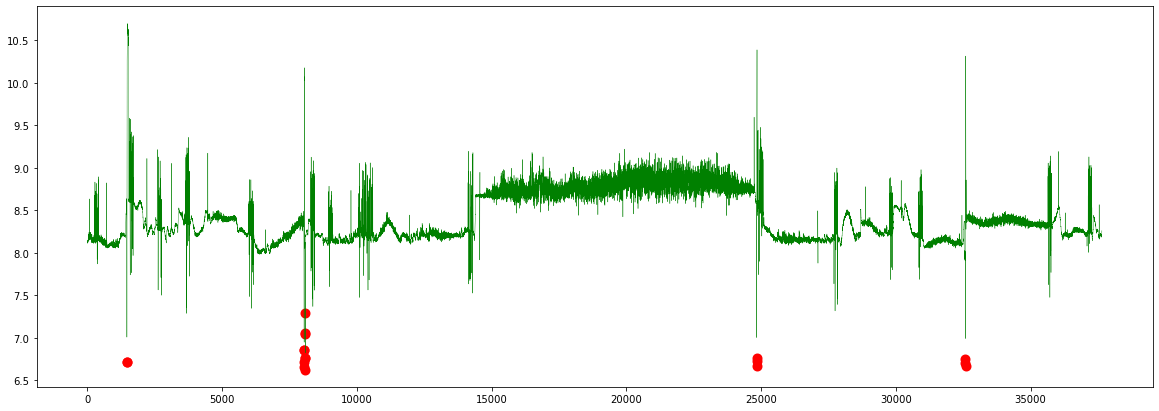

In [15]:
#df1_i[['FLOATVALUE','gmm','anom']].plot(figsize=(15,7))
arr = np.arange(0, df1_i['FLOATVALUE'].values.size)

fig, ax = plt.subplots(1,1,figsize=(20,7))
ax.plot(arr, df1_i['FLOATVALUE'], color='green', lw=0.4)
#ax.plot(arr, df1_i['gmm'], color='violet', lw=0.4)
ax.scatter(arr, df1_i['kde+'], color='red', lw=4)

### Try GMM with more data

In [15]:
num_of_rows = 1024

CSV_Reader = pd.read_csv('./data/IOT_TAGDATA_202112021356.csv.bz2', compression='bz2',
                     parse_dates=['RCV_TIMESTAMP_UTC'], infer_datetime_format=True, chunksize=num_of_rows)
dfs = []
i = 0
for chunk_df in CSV_Reader:
    chunk_df['RCV_TIMESTAMP_UTC'] = pd.to_datetime(chunk_df['RCV_TIMESTAMP_UTC'], format='%Y-%m-%d-%H.%M.%S.%f')
    chunk_df = chunk_df.sort_values('RCV_TIMESTAMP_UTC') #.drop(columns=['TAGID','INTVALUE','STRINGVALUE',
                                                         #              'DATEVALUE','EVT_NAME','DEVICETYPE',
                                                         #              'LOGICALINTERFACE_ID','EVENTTYPE',
                                                         #              'FORMAT','UPDATED_UTC'])
    #chunk_df['FLOATVALUE'].astype(np.float64)
    i+=1
    dfs.append(chunk_df)
    if i > 4000: break
    
df3_raw = pd.concat(dfs, sort=False)

df3_i = df3_raw.sort_values(by=['RCV_TIMESTAMP_UTC']).set_index(['DEVICEID','RCV_TIMESTAMP_UTC'])

### Got all sensors with tag path matching 'ca3e/hvac/scrubbers/shx*'

In [16]:
df3_i['TAG'].unique()

array(['ca3e/hvac/scrubbers/shx7/fit701/eu',
       'ca3e/hvac/scrubbers/shx1/at103/eu',
       'ca3e/hvac/scrubbers/shx1/fit102/eu',
       'ca3e/hvac/scrubbers/shx1/pt101/eu',
       'ca3e/hvac/scrubbers/shx3/at303/eu',
       'ca3e/hvac/scrubbers/shx3/recirctotflow/eu',
       'ca3e/hvac/scrubbers/shx2/at202/eu',
       'ca3e/hvac/scrubbers/shx1/recirctotflow/eu',
       'ca3e/hvac/scrubbers/shx3/fit301/eu',
       'ca3e/hvac/scrubbers/shx3/fit304/eu',
       'ca3e/hvac/scrubbers/shx3/fit302/eu',
       'ca3e/hvac/scrubbers/shx1/fit101/eu',
       'ca3e/hvac/scrubbers/shx3/fan/current',
       'ca3e/hvac/scrubbers/shx3/dpit302/eu',
       'ca3e/hvac/scrubbers/shx1/fit104/eu',
       'ca3e/hvac/scrubbers/shx1/dpit102/eu',
       'ca3e/hvac/scrubbers/shx7/shx7/fan/torque',
       'ca3e/hvac/scrubbers/shx7/shx7/fan/power',
       'ca3e/hvac/scrubbers/shx7/shx7/fan/current',
       'ca3e/hvac/scrubbers/shx1/dpit103/eu',
       'ca3e/hvac/scrubbers/shx7/fit704/eu',
       'ca3e/hvac/scru

### Plotting the first 4 of the list

In [17]:
tag_list = [
            'ca3e/hvac/scrubbers/shx1/at103/eu', 'ca3e/hvac/scrubbers/shx1/pt101/eu',
            'ca3e/hvac/scrubbers/shx1/fit101/eu', 'ca3e/hvac/scrubbers/shx1/fit102/eu',
            'ca3e/hvac/scrubbers/shx1/fit104/eu']

# empty - i.e. suitable data points but we don't have data in db2
#   'ca3e/hvac/scrubbers/shx1/at101/eu', 'ca3e/hvac/scrubbers/shx1/at102/eu', 
#   'ca3e/hvac/scrubbers/shx1/pdit101/eu', 'ca3e/hvac/scrubbers/shx1/pdit102/eu',
#   'ca3e/hvac/scrubbers/shx2/at101/eu', 'ca3e/hvac/scrubbers/shx2/at102/eu',
#   'ca3e/hvac/scrubbers/shx2/at103/eu', 'ca3e/hvac/scrubbers/shx2/pt101/eu',
#   'ca3e/hvac/scrubbers/shx2/pdit101/eu', 'ca3e/hvac/scrubbers/shx2/pdit102/eu',
#   'ca3e/hvac/scrubbers/shx2/fit101/eu', 'ca3e/hvac/scrubbers/shx2/fit102/eu',
#   'ca3e/hvac/scrubbers/shx3/at101/eu', 'ca3e/hvac/scrubbers/shx3/at102/eu',
#   'ca3e/hvac/scrubbers/shx2/fit104/eu', 
# 


ca3e/hvac/scrubbers/shx1/at103/eu
ca3e/hvac/scrubbers/shx1/pt101/eu
ca3e/hvac/scrubbers/shx1/fit101/eu
ca3e/hvac/scrubbers/shx1/fit102/eu


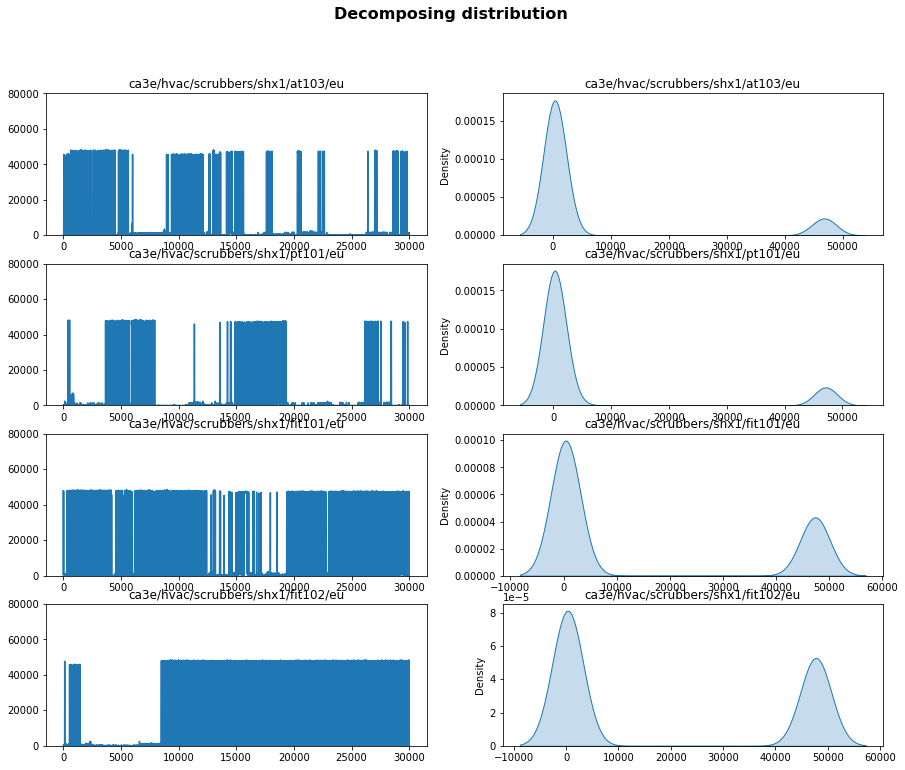

In [18]:
#tag_list = []
i = 0
last = 4

fig, ax = plt.subplots(last, 2, figsize=(15, 3*last),squeeze=False)
fig.suptitle("Decomposing distribution", fontsize=16, fontweight='bold')


#for tag in df3_i['TAG'].unique():
for tag in tag_list:
    
    #tag_list.append(tag)
    print(tag)
    arr = df3_i[df3_i['TAG'] == tag]['FLOATVALUE'][0:30000].values

    ax[i,0].plot(range(arr.size), arr)
    ax[i,0].set_ylim(0, 80000)
    ax[i,0].set_title(tag)
    sns.kdeplot(arr,ax=ax[i,1], fill=True)
    ax[i,1].set_title(tag)

    i+=1
    if i >= last: break

In [19]:
df = df3_i[df3_i['TAG'].isin(tag_list)].reset_index().set_index(['TAG','RCV_TIMESTAMP_UTC'])

In [20]:
df

DEVICEID  \
TAG                                RCV_TIMESTAMP_UTC                                               
ca3e/hvac/scrubbers/shx1/at103/eu  2021-11-01 00:00:06.669  abc99a29-0482-38c6-8b25-22b71bcc0f3f   
                                   2021-11-01 00:00:06.669  abc99a29-0482-38c6-8b25-22b71bcc0f3f   
                                   2021-11-01 00:00:06.669  3631be71-d40e-34e6-af37-daa204642605   
ca3e/hvac/scrubbers/shx1/fit102/eu 2021-11-01 00:00:06.669  e19c13e1-73a1-3222-8778-aee8d5c94004   
ca3e/hvac/scrubbers/shx1/at103/eu  2021-11-01 00:00:06.669  abc99a29-0482-38c6-8b25-22b71bcc0f3f   
...                                                                                          ...   
                                   2021-12-01 16:59:08.949  a026f5e3-6817-3d28-bbbc-068527bfb104   
                                   2021-12-01 16:59:08.949  a026f5e3-6817-3d28-bbbc-068527bfb104   
                                   2021-12-01 16:59:08.949  a026f5e3-6817-3d28-bbbc-068527bfb104   
                                   2021-12-01 16:59:08.949  a026f5e3-6817-3d28-bbbc-068527bfb104   
                                   2021-12-01 16:59:08.949  a026f5e3-6817-3d28-bbbc-068527bfb104   

                                                             TAGID  FLOATVALUE  
TAG                                RCV_TIMESTAMP_UTC                            
ca3e/hvac/scrubbers/shx1/at103/eu  2021-11-01 00:00:06.669  674652    2.400000  
                                   2021-11-01 00:00:06.669  674652    2.400000  
                                   2021-11-01 00:00:06.669  674654  243.000000  
ca3e/hvac/scrubbers/shx1/fit102/eu 2021-11-01 00:00:06.669  674696  253.000000  
ca3e/hvac/scrubbers/shx1/at103/eu  2021-11-01 00:00:06.669  674652    2.400000  
...                                                            ...         ...  
                                   2021-12-01 16:59:08.949  639238    1.590226  
                                   2021-12-01 16:59:08.949  639238    1.590226  
                                   2021-12-01 16:59:08.949  639238    1.590226  
                                   2021-12-01 16:59:08.949  639238    1.590226  
                                   2021-12-01 16:59:08.949  639238    1.590226  

[1066009 rows x 3 columns]

In [21]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

gmm2 = GMMAnomalyScore(Temperature, 2, 3, 'gmm')
gmm2.delete_model = True
et = gmm2._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
gmm2._entity_type = et
df = gmm2.execute(df=df)

2022-01-13T20:43:03.658 DEBUG mmfunctions.anomaly.__init__ init GMM Estimator
2022-01-13T20:43:03.659 DEBUG root.__init__ __init__GMMAnomalyScore
2022-01-13T20:43:03.659 DEBUG root.__init__ __init__ done with parameters: FLOATVALUE.gmm
2022-01-13T20:43:03.660 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.7.0
2022-01-13T20:43:03.660 DEBUG iotfunctions.util.__init__ Starting trace
2022-01-13T20:43:03.660 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GMMAnomalyScore_20220113194303
2022-01-13T20:43:03.661 DEBUG iotfunctions.util.__init__ auto_save None
2022-01-13T20:43:03.661 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-01-13T20:43:03.661 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-01-13T20:43:03.662 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GMMANOMALYSCORE
Functions:
Granularities:
No schedules 

2022-01-13T20:43:18.806 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GMMANOMALYSCORE.GMMAnomalyScore.gmm.ca3e:hvac:scrubbers:shx1:pt101:eu of size 1930 bytes has been retrieved from filesystem
2022-01-13T20:43:18.809 INFO mmfunctions.anomaly.load_model load model Pipeline(steps=[('scale', MinMaxScaler()),
                ('gmm',
                 BayesianGaussianMixture(init_params='random', n_components=2,
                                         n_init=5, verbose=1,
                                         weight_concentration_prior_type='dirichlet_distribution'))])
2022-01-13T20:43:18.809 DEBUG mmfunctions.anomaly.load_model Deleting robust model 0 for entity: ca3e/hvac/scrubbers/shx1/pt101/eu
2022-01-13T20:43:18.811 DEBUG mmfunctions.anomaly._calc Running GMM with (157881, 1)
Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
Initialization converged

Text(0.5, 1.0, 'anomaly score')

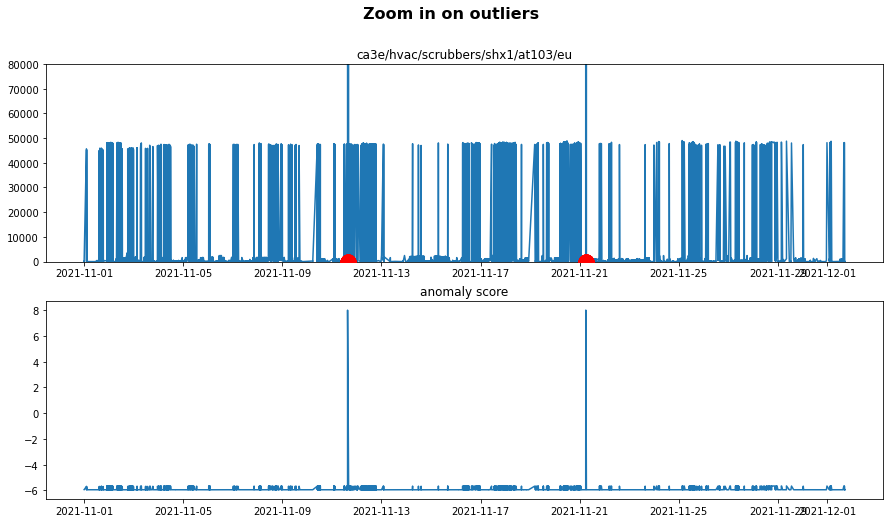

In [22]:
tag = 'ca3e/hvac/scrubbers/shx1/at103/eu'

threshold = 4.6
df_ = df.loc[tag].copy().reset_index()
#df_['gmm'] *= 3000000
garr = df_['gmm'].values.copy()

garr[garr <= threshold] = np.nan #-1
garr[garr > threshold] = 0

fig, ax = plt.subplots(2,1, figsize=(15, 8),squeeze=False)

fig.suptitle("Zoom in on outliers", fontsize=16, fontweight='bold')



ax[0,0].plot(df_['RCV_TIMESTAMP_UTC'].values, df_['FLOATVALUE'].values)
ax[0,0].set_ylim(0, 80000)
ax[0,0].scatter(df_['RCV_TIMESTAMP_UTC'].values, garr, c='red', lw=10, zorder=10)
ax[0,0].set_title(tag)
ax[1,0].plot(df_['RCV_TIMESTAMP_UTC'].values, df_['gmm'].values)
ax[1,0].set_title('anomaly score')
#df_.loc[tag].plot()
#df3_i[df3_i['TAG'] == tag].plot()

In [23]:
#df_.loc[tag].size

ca3e/hvac/scrubbers/shx1/at103/eu
ca3e/hvac/scrubbers/shx1/pt101/eu
ca3e/hvac/scrubbers/shx1/fit101/eu
ca3e/hvac/scrubbers/shx1/fit102/eu


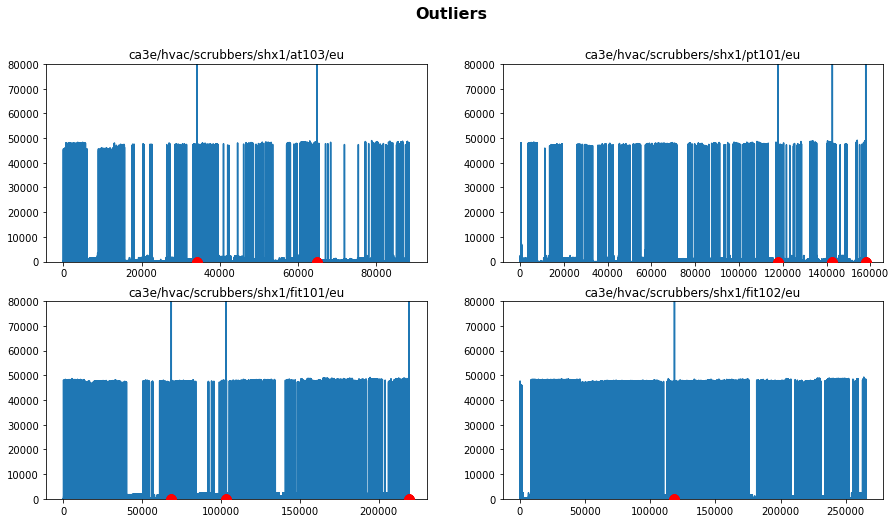

In [24]:

# predictions = negative log-likelihood for sample after scaling
threshold = 4.6 # prob lower than ~1%

i = 0
last = 4

df_ = df.reset_index()

fig, ax = plt.subplots(last//2,2, figsize=(15, 2*last),squeeze=False)

fig.suptitle("Outliers", fontsize=16, fontweight='bold')


for tag in tag_list: #df_['TAG'].unique():
    
    print(tag)
    arr = df_[df_['TAG'] == tag]['FLOATVALUE'].values
    garr = df_[df_['TAG'] == tag]['gmm'].values
    
    #garr[garr < 0] = 0
    garr[garr <= threshold] = np.nan #-1
    garr[garr > threshold] = 0
    #garr[garr < 0] = np.nan


    ax[i//2, i%2].plot(range(arr.size), arr)
    ax[i//2, i%2].scatter(range(garr.size), garr, color='red', zorder=10, lw=4)
    ax[i//2, i%2].set_ylim(0,80000)
    ax[i//2, i%2].set_title(tag)

    i+=1
    if i >= last: break

#### -- snip -- snip -- snip --

Ignore everything below

In [25]:
df_

,TAG,RCV_TIMESTAMP_UTC,DEVICEID,TAGID,FLOATVALUE,gmm
0,ca3e/hvac/scrubbers/shx1/at103/eu,2021-11-01 00:00:06.669,abc99a29-0482-38c6-8b25-22b71bcc0f3f,674652,2.400000,-5.944272
1,ca3e/hvac/scrubbers/shx1/at103/eu,2021-11-01 00:00:06.669,abc99a29-0482-38c6-8b25-22b71bcc0f3f,674652,2.400000,-5.944272
2,ca3e/hvac/scrubbers/shx1/at103/eu,2021-11-01 00:00:06.669,3631be71-d40e-34e6-af37-daa204642605,674654,243.000000,-5.944713
3,ca3e/hvac/scrubbers/shx1/at103/eu,2021-11-01 00:00:06.669,abc99a29-0482-38c6-8b25-22b71bcc0f3f,674652,2.400000,-5.944272
4,ca3e/hvac/scrubbers/shx1/at103/eu,2021-11-01 00:00:06.669,abc99a29-0482-38c6-8b25-22b71bcc0f3f,674652,2.400000,-5.944272
...,...,...,...,...,...,...
1066004,ca3e/hvac/scrubbers/shx1/at103/eu,2021-12-01 16:59:08.949,a026f5e3-6817-3d28-bbbc-068527bfb104,639238,1.590226,-5.944270
1066005,ca3e/hvac/scrubbers/shx1/at103/eu,2021-12-01 16:59:08.949,a026f5e3-6817-3d28-bbbc-068527bfb104,639238,1.590226,-5.944270
1066006,ca3e/hvac/scrubbers/shx1/at103/eu,2021-12-01 16:59:08.949,a026f5e3-6817-3d28-bbbc-068527bfb104,639238,1.590226,-5.944270
1066007,ca3e/hvac/scrubbers/shx1/at103/eu,2021-12-01 16:59:08.949,a026f5e3-6817-3d28-bbbc-068527bfb104,639238,1.590226,-5.944270


### Decompose into a mix of Gaussians

or something else if it makes sense and you care to derive the formula for the combined log-likelihood.

Apparently I copied it from another notebook for another customer in Spring 2021 ...
which I used as excuse to dabble a bit in MCMC ;-)

$$
  \log p(x) = -\frac{k \log(2 \pi)}{2} + \log( \frac{1}{\det (T)}) + (x - \mu) T (x - \mu)
$$

In [166]:
# https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html
import pymc3 as pm
import theano.tensor as tt

from pymc3 import (NUTS, DensityDist, Dirichlet, HalfCauchy, LKJCorr,
                   Metropolis, MvNormal, Normal, Slice, find_MAP, sample)
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det

logging.getLogger("filelock").setLevel(logging.ERROR)


# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * tt.log(2 * np.pi)
        + tt.log(1.0 / det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )

In [192]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = RobustScaler()
data_ = scaler.fit_transform(df_['FLOATVALUE'].values.reshape(-1,1))

# turn it into 2-dim data for testing purposes
data = np.hstack([data_[0:10000], data_[0:10000]])
data = data_[0:10000]
data.shape

(10000, 1)

In [206]:
p=3
mu=[.03,.05,-.02]
cov_matrix= [[.025,0.0075, 0.00175],[0.0075,.007,0.00135],[0.00175,0.00135,.00043]]

n_obs=10000
x=np.random.multivariate_normal(mu,cov_matrix,n_obs)

prior_mu=np.ones(p)

prior_sigma = np.eye(p)
print(prior_mu,'\n', prior_sigma)


with pm.Model() as model:
    post_mu = pm.Normal("returns", prior_mu, 1, shape=3)  #, size=p)
    #post_cov_matrix_inv = pm.Wishart("cov_matrix_inv",n_obs,np.eye(3) )
    
    prec = pm.WishartBartlett('prec', np.eye(3), 5)
    post_cov_matrix_inv = pm.Deterministic('cov', tt.nlinalg.matrix_inverse(prec))

    obs = pm.MvNormal( "observed returns", post_mu, post_cov_matrix_inv, observed=x )
    
    #mcmc = pm.MCMC()
'''

mcmc.sample( 5000, 2000, 3 )

mu_samples = mcmc.trace("returns")[:]
mu_samples.mean(axis=0)
cov_inv_samples = mcmc.trace("cov_matrix_inv")[:]
mean_covariance_matrix = np.linalg.inv( cov_inv_samples.mean(axis=0) )
'''

[1. 1. 1.] 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
2022-01-14T20:51:12.873 DEBUG pymc3.Var Applied log-transform to prec_c and added transformed prec_c_log__ to model.
2022-01-14T20:51:12.874 INFO pymc3.WishartBartlett Added new variable prec_c to model diagonal of Wishart.
2022-01-14T20:51:12.921 INFO pymc3.WishartBartlett Added new variable prec_z to model off-diagonals of Wishart.


'\n\nmcmc.sample( 5000, 2000, 3 )\n\nmu_samples = mcmc.trace("returns")[:]\nmu_samples.mean(axis=0)\ncov_inv_samples = mcmc.trace("cov_matrix_inv")[:]\nmean_covariance_matrix = np.linalg.inv( cov_inv_samples.mean(axis=0) )\n'

In [207]:
with model:
    #%time approx = pm.fit(n=400, obj_optimizer=pm.adagrad(learning_rate=1e-1))
    %time approx = pm.fit(n=4000, obj_optimizer=pm.adadelta())

2022-01-14T20:51:53.719 INFO pymc3.variational.inference._iterate_with_loss Finished [100%]: Average Loss = -34,793
CPU times: user 51.7 s, sys: 57.7 s, total: 1min 49s
Wall time: 37.1 s


In [214]:
means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov) ** 0.5)

In [218]:
sds

{'prec_z': array([0.29614812, 0.41322867, 0.36062288]),
 'prec_c_log__': array([0.10027926, 0.10470086, 0.14956471]),
 'returns': array([0.02341405, 0.01775408, 0.0121095 ])}

In [168]:
#sns.histplot(data=data.T).set_title('Almost bimodal distribution')

$$
  p(x) = \sum \phi_i \mathcal{N}(x | \mu_i, \sigma_i)
$$

In [219]:
# define simplified model - we expect our 2-dim data generated by 2 additive gaussians
ncomp = 2
dim = data.shape[1]

# Log likelihood of Gaussian mixture distribution
#   takes the list of mys, 
def logp_gmix(mus, phi, tau):
    def logp_(value):
        #print(tau.shape, mus, phi.shape)
        
        # ps  is list of probability for each Gaussian * how likely the value is for that Gaussian
        logps = [tt.log(phi[i]) + logp_normal(mu, tau, value) for i, mu in enumerate(mus)]
        print(logps)
        # unravel and add up
        print (logsumexp(tt.stacklists(logps)[:, :data.shape[0]], axis=0))
        return tt.sum(logsumexp(tt.stacklists(logps)[:, :data.shape[0]], axis=0))

    return logp_



with pm.Model() as model:
    
    # start with 2 normal dists
    mus = [
        MvNormal("mu_%d" % i, mu=pm.floatX(np.zeros(dim)), tau=pm.floatX(0.1 * np.eye(dim)), shape=(dim,))
        for i in range(ncomp)
    ]
    # usually we would draw mean and precision matrix from Normal, resp. Wishart
    #   but Wishart doesn't 
    
    # prior for the Gaussian components
    phi = Dirichlet("phi", a=pm.floatX(0.1 * np.ones(ncomp)), shape=(ncomp,))
    xs = DensityDist("x", logp_gmix(mus, phi, np.eye(dim)), observed=data)
    
    # Specify the likelihood
    #Y_obs = pm.Normal('Y_obs', mu=mu[z], sd=sigma[z], observed=y)

2022-01-17T10:11:46.891 DEBUG pymc3.Var Applied stickbreaking-transform to phi and added transformed phi_stickbreaking__ to model.
[Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0]
Elemwise{add,no_inplace}.0
[Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0]
Elemwise{add,no_inplace}.0
[Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0]
Elemwise{add,no_inplace}.0


In [180]:
%%time

'''
with model:
    start = find_MAP()
    step = Slice()
    trace = sample(100, step, start=start)

'''
with model:
    #%time approx = pm.fit(n=400, obj_optimizer=pm.adagrad(learning_rate=1e-1))
    %time approx = pm.fit(n=4000, obj_optimizer=pm.adadelta())

#'''
means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov) ** 0.5)

2022-01-14T18:57:47.471 INFO pymc3.variational.inference._iterate_with_loss Finished [100%]: Average Loss = 38,874
CPU times: user 5.88 s, sys: 37 ms, total: 5.92 s
Wall time: 5.9 s
CPU times: user 5.9 s, sys: 37.8 ms, total: 5.94 s
Wall time: 5.91 s


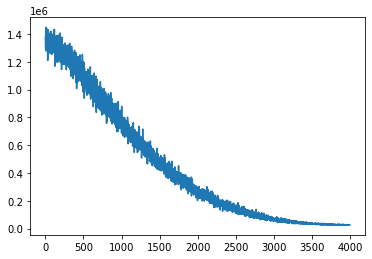

In [181]:
plt.plot(approx.hist)

In [182]:
sds

{'mu_1': array([0.34229337, 0.42382108]),
 'phi_stickbreaking__': array([0.0156093]),
 'mu_0': array([0.02720644, 0.02214241])}

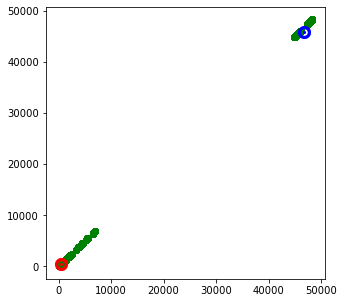

In [183]:
mu_0, mu_1 = scaler.inverse_transform(np.array([means["mu_0"], means["mu_1"]]))
data2 = scaler.inverse_transform(data)#[:, 0])

plt.figure(figsize=(5, 5))
plt.scatter(data2, data2, alpha=0.5, c="g")
#mu_0, mu_1 = means["mu_0"], means["mu_1"]
plt.scatter(mu_0[0], mu_0[1], c="r", lw=10, s=10)
plt.scatter(mu_1[0], mu_1[1], c="b", lw=10, s=10)
#plt.xlim(-6, 6)
#plt.ylim(-6, 6)


In [117]:
import theano.tensor as tt
data = df_input['temp'].values
ndata = data.size

model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet("p", a=np.array([1.0, 1.0]), shape=2)
    # ensure all clusters have some points
    p_min_potential = pm.Potential("p_min_potential", tt.switch(tt.min(p) < 0.1, -np.inf, 0))

    # cluster centers
    means = pm.Normal("means", mu=[0, 0], sigma=15, shape=2)
    # break symmetry
    '''
    order_means_potential = pm.Potential(
        "order_means_potential",
        tt.switch(means[1] - means[0] < 0, -np.inf, 0)
        + tt.switch(means[2] - means[1] < 0, -np.inf, 0),
    )
    '''

    # measurement error
    sd = pm.Uniform("sd", lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical("category", p=p, shape=ndata)

    # likelihood for each observed value
    points = pm.Normal("obs", mu=means[category], sigma=sd, observed=data)

In [131]:
map_estimate = pm.find_MAP(model=model) #, method="powell")

In [132]:
map_estimate

{'p_stickbreaking__': array([-105.5628586]),
 'means': array([581.63975217,   0.        ]),
 'sd_interval__': array(219.90625439),
 'category': array([0, 0, 0, ..., 0, 0, 0]),
 'p': array([2.22044605e-16, 1.00000000e+00]),
 'sd': array(20.)}

In [130]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category], proposal = 'uniform')
    tr = pm.sample(10000, step=[step1, step2], tune=2000)

2021-02-07T17:38:47.098 INFO pymc3.sample Multiprocess sampling (4 chains in 4 jobs)
2021-02-07T17:38:47.099 INFO pymc3._print_step_hierarchy CompoundStep
2021-02-07T17:38:47.099 INFO pymc3._print_step_hierarchy >CompoundStep
2021-02-07T17:38:47.099 INFO pymc3._print_step_hierarchy >>Metropolis: [means]
2021-02-07T17:38:47.100 INFO pymc3._print_step_hierarchy >>Metropolis: [sd]
2021-02-07T17:38:47.100 INFO pymc3._print_step_hierarchy >>Metropolis: [p]
2021-02-07T17:38:47.100 INFO pymc3._print_step_hierarchy >CategoricalGibbsMetropolis: [category]


ValueError: Not enough samples to build a trace.

/home/markus/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


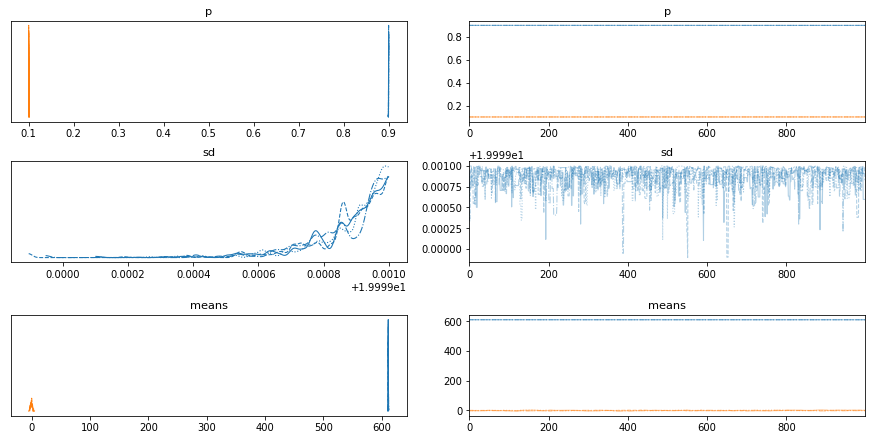

In [121]:
pm.traceplot(tr, var_names=["p", "sd", "means"]);

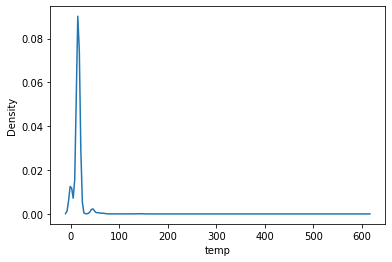

In [104]:
sns.kdeplot(data=df_input2['temp'])

<Figure size 1728x720 with 0 Axes>

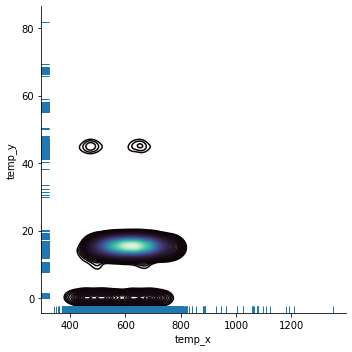

In [89]:
df_merge2 = df_merge.copy()
df_merge2 = df_merge2[df_merge2['temp_y'] < 100]

import seaborn as sns
plt.figure(figsize=(24, 10))
gx = sns.displot(df_merge2[['temp_x','temp_y']], x='temp_x', y='temp_y', 
                 levels=100, kind="kde", cmap="mako", rug=True)
    
#gx.set_titles('KDE for' + df_clean.index.levels[0].values[0])